In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# Imports

# third party
import jax
import jax.numpy as jnp
from jax._src.config import config
import matplotlib.pyplot as plt 
config.update("jax_enable_x64", True) #SHOULDN'T NEED THIS ANYMORE -- but just for safety
plt.style.use('/Users/juan/phd/matplotlib/jdefault.mplstyle')
from astropy.stats import histogram
#need to get rid of
import numpy as np
# project
from dynamicAll import models,sampler

In [78]:
model_params = {
    'M' : 1e5,
    'a': 0.5
}

In [79]:
model = models.Plummer(**model_params)

In [80]:
samples= model.sample_w_conditional(N=10_000,evolve=False,save=False)

In [81]:
x  = samples[:,0]
y  = samples[:,1]
z  = samples[:,2]
vx = samples[:,3]
vy = samples[:,4]
vz = samples[:,5]
r  = np.sqrt(x**2 + y**2 + z**2)
vr = (x*vx + y*vy + z*vz)/r
v = np.sqrt(vx**2 + vy**2 + vz**2)

In [ ]:
def g_q(q):
    '''
    Probability distribution for q = v/v_esc.

    Parameters
    ----------
    q : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    '''
    return q**2*(1-q**2)**(7/2)* (512/(7*np.pi))

[None,
 (0.0, 3.0),
 Text(0.5, 0, '$q =\\frac{v}{v_{esc}}(r)$'),
 Text(0, 0.5, '$pdf(q)$')]

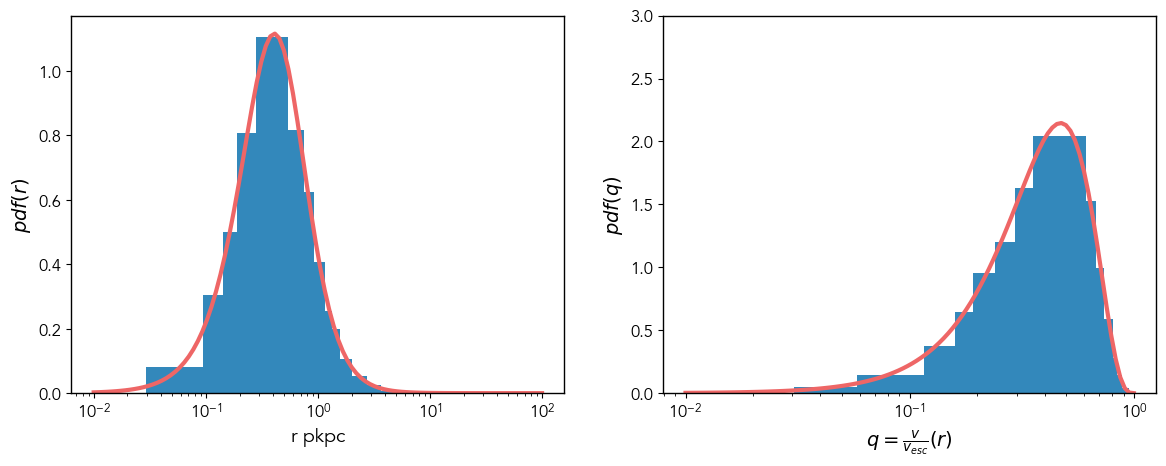

In [91]:
fig,ax = plt.subplots(ncols=2,figsize=(14,5))
r_test = np.logspace(-2,2,100)
N,bin_edges = histogram(r,bins='blocks')
q = v/model.v_esc(r)
# sanity checks
N,vel_edges = histogram(q,bins='blocks')
q_test = np.logspace(-2,0,100)


ax[0].hist(r,bins=bin_edges,density='True')
ax[0].plot(r_test,model.probability(r_test))
ax[0].set(
    xscale = 'log',
    xlabel = 'r pkpc',
    ylabel =r'$pdf(r)$' 
)



ax[1].hist(q,bins=vel_edges,density=True);
ax[1].plot(q_test,g_q(q_test))
ax[1].set(
    xscale='log',
    ylim = (0,3),
    xlabel=r'$q =\frac{v}{v_{esc}}(r)$',
    ylabel=r'$pdf(q)$'
)

## Now the same thing with a more general sampler that samples from $\vec{w}$ all at once

In [93]:
test_samples = model.sample_w(N=10_000,save=False)
x = test_samples[:,0]
y = test_samples[:,1]
z = test_samples[:,2]
vx = test_samples[:,3]
vy = test_samples[:,4]
vz = test_samples[:,5]
r_test = np.sqrt(x**2 + y**2 + z**2)
vr_test = (x*vx + y*vy + z*vz)/r_test

/opt/homebrew/Caskroom/miniforge/base/envs/py10/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Mean acceptance fraction: 0.475
Mean autocorrelation time: 86.200 steps


The initial warning doesnt mean anything besides that i should initialize the walkers in the sampler more reasonably so that all of them are finite, but it doesnt affect the results.
We can compare the results of the two sampler and make sure we're essentially getting the same thing.
The emcee sampler will be more useful in cases where the marginalization done in the original plummer model cant be done as nicely as in the case of the plummer sphere

## compare velocity dispersions

In [101]:
from astropy.stats import histogram
from scipy.stats import binned_statistic
r_center     = .5*(bin_edges[:-1]+ bin_edges[1:]) 
meanv = jnp.mean(v) # Probably shouldn't assume that v_{com} = 0
meanv,_,bin_numbers   = binned_statistic(r,vr,'mean',bins=bin_edges)
mu,_,bin_numbers   = binned_statistic(r,vr**2,'mean',bins=bin_edges)

In [102]:
# N, bin_edges = histogram(r_test,bins = '') # just cause theres a lot of points --
r_center2     = .5*(bin_edges[:-1]+ bin_edges[1:]) 
# meanv = jnp.mean(v) # Probably shouldn't assume that v_{com} = 0
meanv2,_,bin_numbers   = binned_statistic(r_test,vr_test,'mean',bins=bin_edges)
mu2,_,bin_numbers   = binned_statistic(r_test,vr_test**2,'mean',bins=bin_edges)

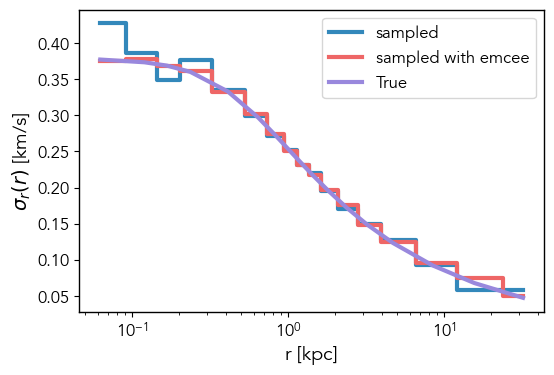

In [103]:
def dispersion(r,M,a):
    G = 4.300917270036279e-06 #kpc km^2 s^-2 Msun^-1
    return G*M/(6*np.sqrt(r**2 + a**2))
    

fig,ax = plt.subplots()
ax.step(r_center,np.sqrt(mu- meanv**2),where='mid',label='sampled')
ax.step(r_center2,np.sqrt(mu2- meanv2**2),where='mid',label='sampled with emcee')
ax.plot(r_center,np.sqrt(dispersion(r_center,model._M,model._a)),label='True')
ax.set(
    xscale='log',
    xlabel = 'r [kpc]',
    ylabel =r'$\sigma_r(r)$ [km/s]',
    # ylim = (0,1),
)
ax.legend()
